###  Zhao, Morrison, Parr Inversion Method:

In [1]:
import os
import psi4
import matplotlib.pyplot as plt
import numpy as np
# import numpy_html
psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

#Define Psi4 geometries. Symmetries need to be set to C1. 

He = psi4.geometry( 
""" 
0 1
He 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""" )

Be = psi4.geometry( 
""" 
0 1
Be 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""" )

Ne = psi4.geometry( 
""" 
0 1
Ne 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""" )


#n2v is driven by psi4's reference option. Make sure you set it accordingly. 
psi4.set_options({"reference" : "uhf"})

#Perform a calculation for a target density. 
#Remember that for post scf calculations, Psi4 does not update the density. 
#Thus make sure you obtain something like a dipole in order to do so. 
e, wfn_he = psi4.properties("hf/ugbs", return_wfn=True, properties=["dipole"], molecule=He)
e, wfn_be = psi4.properties("hf/ugbs", return_wfn=True, properties=["dipole"], molecule=Be)
e, wfn_ne = psi4.properties("hf/ugbs", return_wfn=True, properties=["dipole"], molecule=Ne)

#Define inverter objects for each molcule. Simply use the wnf object from psi4 as an argument. 
ihe = n2v.Inverter(wfn_he)
ibe = n2v.Inverter(wfn_be)
ine = n2v.Inverter(wfn_ne)

#### Let us now invert the density using the [Zhao, Morrison, Parr Method](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.50.2138):

---
##### The Zhao, Morrison, Parr method works by updating self-consistently a potential generated by the difference in density. 
#The driving potential at each stage of the scf calculation is:

$$v_c^i(r) = \lambda \int \frac{n_i(r') - n_{0}(r')}{|r-r'|} dr'$$

where $n(r)$ is the current density iteration and $n_0(r)$ is the target density that remains fixed during the scf procedure.

The $\lambda$ parameter is a Lagrange multiplier that in the limit of $\lambda \rightarrow \infty$, allows $v_c$ to become the exact potential. In practice we won't be able to increase lambda arbitrarily but values like $25$, $50$ or $75$ are commonly used. An iterative approach also lets you perform an extrapolation technique iteratively. In order to trigger this calculation, specify more than one lambda. A reliable option to choose is to begin with $\lambda=10$ and make enough iterations to achieve desired convergence in density. 

The algorithm will need an initial potential components to guide the inversion procedure. It is common to use the "Fermi Amaldi" (FA) Potential. Let us now use all of the previous information to perform the desired inversions. 

In [12]:
ihe.invert("zmp", opt_max_iter=100, opt_tol=1e-9, zmp_mixing=0.01, zmp_lam=np.linspace(10,100,10), guide_potential_components=["fermi_amaldi"])
ibe.invert("zmp", opt_max_iter=100, opt_tol=1e-9, zmp_mixing=0.01, zmp_lam=np.linspace(10,100,10), guide_potential_components=["fermi_amaldi"])
ine.invert("zmp", opt_max_iter=100, opt_tol=2e-9, zmp_mixing=0.01, zmp_lam=np.linspace(10,1000,100), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 9.885615659399605e-10

ZMP halted. Density Difference is unable to be reduced

Running ZMP:
SCF Converged for lambda:   10. Max density difference: 0.21215477193587695
SCF Converged for lambda:   20. Max density difference: 0.011551144497135013

ZMP halted. Density Difference is unable to be reduced

Running ZMP:
SCF Converged for lambda:   10. Max density difference: 4.229637557892403
SCF Converged for lambda:   20. Max density difference: 1.3858555938631127
SCF Converged for lambda:   30. Max density difference: 1.2313743205984622
SCF Converged for lambda:   40. Max density difference: 0.6819749005408369
SCF Converged for lambda:   50. Max density difference: 0.6180729036009609
SCF Converged for lambda:   60. Max density difference: 0.39017664868956103
SCF Converged for lambda:   70. Max density difference: 0.3561480679611577
SCF Converged for lambda:   80. Max density difference: 0.23301155818612074
SCF Converged 

---
##### The potential that we are looking for is driven by density difference. The potential is then added to the Fock matrix as Hartree contribution. 
##### Thus if we want to visualize the potential, we need to compute the Hartree of a combination of the obtained density and the target density according to:

$$
v_{xc}(r) = v_c(r) - (1-1/N) \cdot v_{FA}(r)
$$

In practice, the result from the scf calculation is stored in:
```
inverter.proto_density_a
inverter.proto_density_b
```
We need to provide this information to the Hartree generating function. This function uses the density stored in the initial wfn object. Thus we need to overwrite this quantity. (Be careful, this is a destructive action that will permanently remove the density within the wfn object).

In [8]:
wfn_he.Da().np[:] = ihe.proto_density_a
wfn_he.Db().np[:] = ihe.proto_density_b

##### Finally we plot as if we were trying to extract the Hartree potential:

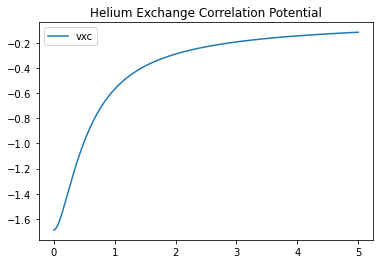

In [9]:
npoints=400
x = np.linspace(-0,5,npoints)[:,None]
y = np.linspace(-0,5,npoints)[:,None]
z = np.linspace(-0,5,npoints)[:,None]
grid = np.concatenate((x,y,z), axis=1).T


results = ihe.on_grid_esp(grid=grid, )
vxc_he = results[1]
    
plt.plot(x,  vxc_he, label="vxc")
plt.title("Helium Exchange Correlation Potential")
plt.legend()
# plt.xlim(0,5)
# plt.ylim(-2.2,0.2)



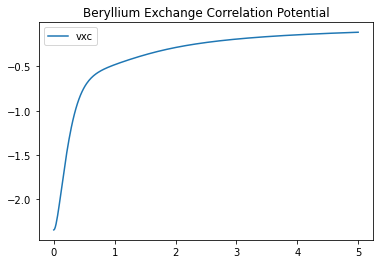

In [10]:
wfn_be.Da().np[:] = ibe.proto_density_a
wfn_be.Db().np[:] = ibe.proto_density_b
results = ibe.on_grid_esp(grid=grid, )
vxc_be = results[1]

plt.plot(x,  vxc_be, label="vxc")
plt.title("Beryllium Exchange Correlation Potential")

plt.legend()
# plt.xlim(0,5)
# plt.ylim(-4,1)


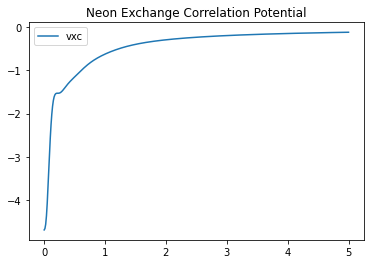

In [11]:
wfn_ne.Da().np[:] = ine.proto_density_a
wfn_ne.Db().np[:] = ine.proto_density_b
results = ine.on_grid_esp(grid=grid, )
vxc_ne = results[1]

plt.plot(x,  vxc_ne, label="vxc")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
# plt.xlim(0,5)
# plt.ylim(-10,1)



In [ ]:
#Potentials can also be visualized in 2d and 3d according to the other different tutorials on this repo. 